## Modeling 
Building Models: Linear Regression and Random Forest Regressor

## 3.1) Importing Essential Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from  sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score


!pip install xgboost
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 215.2 kB/s  0:07:37m0:00:0200:14
   ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.2/295.9 MB 212.4 kB/s eta 0:21:34^C
   ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.2/295.9 MB 212.4 kB/s eta 0:21:34
ERROR: Operation cancelled by user


## 3.2) Load processed data

In [2]:
df = pd.read_csv('../data/walmart_features.csv')

# Split data into target and features
y = df['weekly_sales']
x = df.drop(columns=['weekly_sales', 'date'])

### 3.3) Train Test Split

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)


### Hyperparameter Tuning

In [ ]:
param_grid = {
    'n_estimators': [200, 500, 800, 1000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

### 3.4) First model: Linear Regression

In [4]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
print("Linear Regression MAE:", mae_lr)
lr_r2 = r2_score(y_test, y_pred_lr)
print("Linear Regression R²:", lr_r2)

Linear Regression MAE: 64606.29525460997
Linear Regression R²: 0.9399586081205946


### 3.5) Second model: Random Forest

In [5]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
print("Random Forest MAE:", mae_rf)
rf_r2 = r2_score(y_test, y_pred_rf )
print("Random Forest R2:", rf_r2)

Random Forest MAE: 47568.304202290055
Random Forest R2: 0.9694492126410623


### 3.6) Third model: XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,              # number of random combinations to try
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    random_state=42
)

random_search.fit(x_train, y_train)

y_pred_xg = random_search.predict(x_test)

mae = mean_absolute_error(y_test, y_pred_xg)
r2 = r2_score(y_test, y_pred_xg)

print("Best Parameters:", random_search.best_params_)
print("Best Score (MAE):", -random_search.best_score_)

print("XGBoost MAE:", mae)
print("XGBoost R²:", r2)

### 3.6) Save models

In [6]:
import joblib

joblib.dump(rf, "../models/random_forest.pkl")
joblib.dump(lr, "../models/linear_regression.pkl")

['../models/linear_regression.pkl']

### Visualizing Predictions vs Actuals (Random Forest)

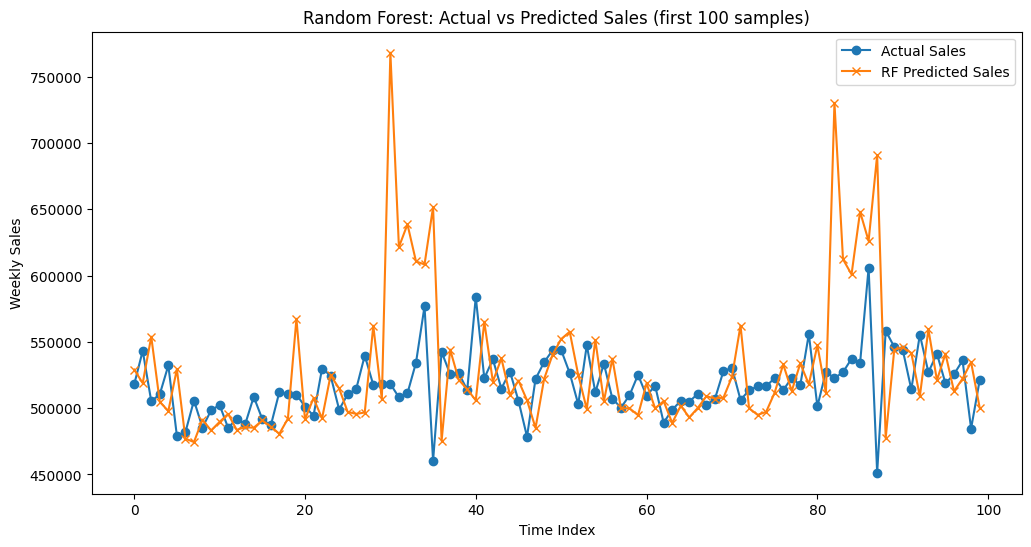

In [11]:
plt.figure(figsize=(12,6))
plt.plot(y_pred_rf[:100], label="Actual Sales", marker='o')
plt.plot(y_pred_rf [:100], label="RF Predicted Sales", marker='x')

plt.title("Random Forest: Actual vs Predicted Sales (first 100 samples)")
plt.xlabel("Time Index")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()

### Residual Plot (Random Forest)

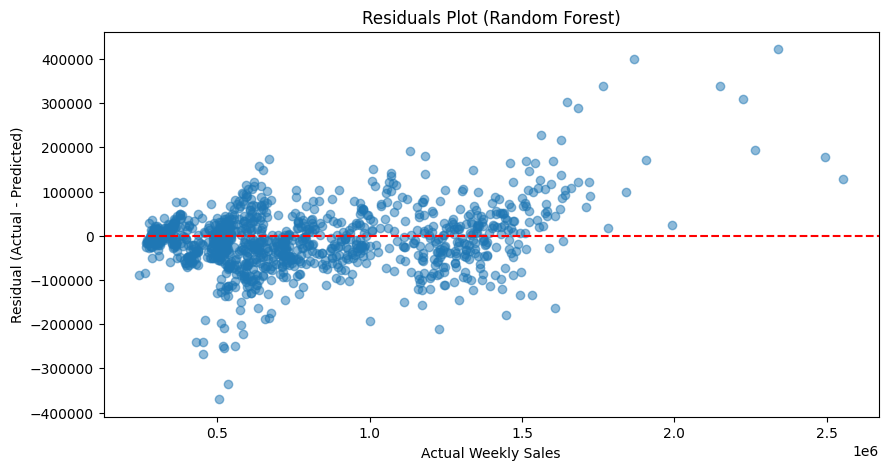

In [15]:
residuals = y_test.values - y_pred_rf

plt.figure(figsize=(10,5))
plt.scatter(y_test.values, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')

plt.title("Residuals Plot (Random Forest)")
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()
